<a href="https://colab.research.google.com/github/ilopezfr/Experiments/blob/master/ig_DeOldify_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeOldify on Colab #

This notebook shows how to get your own version of [DeOldify](https://github.com/jantic/DeOldify) working on Google Colab. A lot of the initial steps are just installs -- but these are also the steps that can make running the model a tedious exercise.

Initially, one must `pip install` a few dependencies, then `wget` is used to download the appropriate picture data.

NECESSARY PRELIMINARY STEP: Please make sure you have gone up to the "Runtime" menu above and "Change Runtime Type" to Python3 and GPU.

I hope you have fun, and thanks to Jason Antic for this awesome tool!

-Matt Robinson, <matthew67robinson@gmail.com>

NEW: You can now load your files from you own Google Drive, check the last cell of the notebook for more information.

In [0]:
!git clone https://github.com/jantic/DeOldify.git DeOldify

In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

In [0]:
cd DeOldify

/content/DeOldify


In [0]:
!pip install -e .

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
# Doing work so I can access data from my google drive
!pip install PyDrive

In [0]:
# Work around with Pillow being preinstalled on these Colab VMs, causing conflicts otherwise.
!pip install Pillow==4.1.1

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import multiprocessing
from torch import autograd
from fastai.transforms import TfmType
from fasterai.transforms import *
from fastai.conv_learner import *
from fasterai.images import *
from fasterai.dataset import *
from fasterai.visualize import *
from fasterai.callbacks import *
from fasterai.loss import *
from fasterai.modules import *
from fasterai.training import *
from fasterai.generators import *
from fastai.torch_imports import *
from fasterai.filters import *
from pathlib import Path
from itertools import repeat
from google.colab import drive
from IPython.display import Image
import tensorboardX
torch.cuda.set_device(0)
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Note that the above requires a verification step. It isn't too bad.

In [0]:
# Now download the pretrained weights, which I have saved to my google drive
# note that the id is the ending part of the shareable link url (after open?id=)
# The pretrained weights can be downloaded from https://www.dropbox.com/s/7r2wu0af6okv280/colorize_gen_192.h5
download = drive.CreateFile({'id': '1mRRvS3WIHPdp36G0yc1jC0XI6i-Narv6'})
download.GetContentFile('pretrained_weights.h5')

With access to your Google Drive, the "deOldifyImages" directory will be created. Drop there your personal images, and after the full execution of the notebook find the results at its subdirectory "results"

**Only need to run the first time**

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')
#!mkdir "/content/drive/My Drive/deOldifyImages"
#!mkdir "/content/drive/My Drive/deOldifyImages/results"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/deOldifyImages’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/deOldifyImages/results’: File exists


In [0]:
weights_path = 'pretrained_weights.h5'
results_dir='/content/drive/My Drive/deOldifyImages/results'

#The higher the render_factor, the more GPU memory will be used and generally images will look better.  
#11GB can take a factor of 42 max.  Performance generally gracefully degrades with lower factors, 
#though you may also find that certain images will actually render better at lower numbers.  
#This tends to be the case with the oldest photos.
render_factor=42
filters = [Colorizer34(gpu=0, weights_path=weights_path)]
vis = ModelImageVisualizer(filters, render_factor=render_factor, results_dir=results_dir)

In [0]:
# download an example picture to try.
# NOTE: All the jpg files cloned from the git repo are corrupted. Must download yourself.
!wget "https://media.githubusercontent.com/media/jantic/DeOldify/master/test_images/abe.jpg" -O "abe2.jpg"
!wget "https://www.monoimages.com/wp-content/uploads/edd/2017/11/painted-ladies-san-francisco-usa-victorian-edwardian-houses-old-history-historic-780x520.jpeg" -O "ladies.jpg"

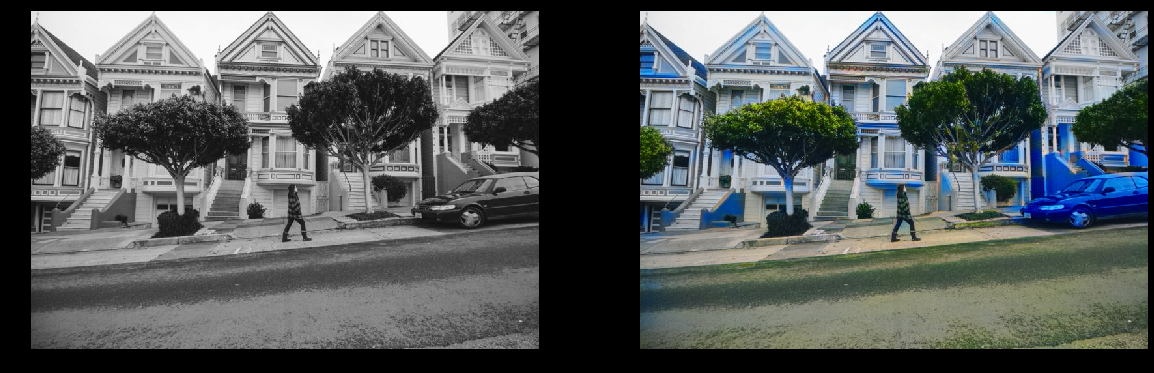

In [0]:
# %matplotlib inline
vis.plot_transformed_image('ladies.jpg', render_factor=25)

In [0]:
!wget "https://media.githubusercontent.com/media/jantic/DeOldify/master/test_images/TV1930s.jpg" -O "family_TV.jpg"

# New Section

In [0]:
vis.plot_transformed_image('family_TV.jpg', render_factor=41)

Let's see how well it does Dorothy before her world turns to color in the Wizard of Oz:

In [0]:
!wget "https://magnoliaforever.files.wordpress.com/2011/09/wizard-of-oz.jpg" -O "Dorothy.jpg"

In [0]:
vis.plot_transformed_image('Dorothy.jpg', render_factor=30)

Let's now try Butch and Sundance. Famously the last scene ends with a black and white still. So we know what the color was beforehand.

In [0]:
!wget "https://i.ebayimg.com/images/g/HqkAAOSwRLZUAwyS/s-l300.jpg" -O "butch_and_sundance.jpg"

In [0]:
vis.plot_transformed_image('butch_and_sundance.jpg', render_factor=29)

Let's get a picture of what they were actually wearing:

In [0]:
!wget "https://bethanytompkins.files.wordpress.com/2015/09/freezeframe.jpg" -O "butch_and_sundance_color.jpg"

In [0]:
Image('butch_and_sundance_color.jpg')

If you want to colorise pictures from your drive, drop them in a directory named deOldifyImages (in the root of your drive) and the next cell will save the colorise pictures in deOldifyImages/results.

In [0]:
for img in os.listdir("/content/drive/My Drive/deOldifyImages/"):
  img_path = str("/content/drive/My Drive/deOldifyImages/") + img
  if os.path.isfile(img_path):
    vis.plot_transformed_image(img_path)